# Theta*: Any-Angle Path Planning on Grids

In this lab, we implement **Theta\***, an any-angle modification of the A* algorithm. We keep A*’s best-first search (Open/Closed) but change the expansion using a line-of-sight (LOS) shortcut. $\text{LOS}(a,b)$ returns true when the straight segment between the centers of cells $a$ and $b$ crosses only free cells.

To be more precise, when expanding $s$, for each neighbor $\text{neighbor}_s$:
- If $s$ has a parent $p$ and $\text{LOS}(p,\text{neighbor}_s)$ is true, compute the shortcut
  $$\tilde g = g(p) + d(p,\text{neighbor}_s)$$
- Otherwise, use the standard update
  $$\tilde g = g(s) + d(s,\text{neighbor}_s)$$

Where $d(x, y)$ is euclidean distance between calls $x$ and $y$.

This proccess is called **expansion**. Eventually, if $\tilde g < g(\text{neighbor}_s)$, then same updates (for SearchNode) as in A* algorithm apply.

Theta\* produces paths closer to true Euclidean shortest paths while keeping computational cost modest for practical applications.


![img1](./images/img1.png)
![img2](./images/img2.png)

In [13]:
from typing import Callable, Iterable, Optional, Tuple, Type

%matplotlib inline

## Grid Map Representation 

In [14]:
from utils.Map import Map
help(Map)

Help on class Map in module utils.Map:

class Map(builtins.object)
 |  Map(cells: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]])
 |
 |  Represents a square grid environment for our moving agent.
 |
 |  Attributes
 |  ----------
 |  _width : int
 |      The number of columns in the grid.
 |
 |  _height : int
 |      The number of rows in the grid.
 |
 |  _cells : np.ndarray
 |      A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
 |
 |  Methods defined here:
 |
 |  __init__(self, cells: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]])
 |      Initializes the map using a 2D array of cells.
 |
 |      Parameters
 |      ----------
 |      cells : np.ndarray
 |          A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
 |
 |  get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]
 |      Gets a list of neighboring cells as (i, j) tuples.
 |  

## Search Node

In [15]:
from utils.Node import Node
help(Node)

Help on class Node in module utils.Node:

class Node(builtins.object)
 |  Node(i: int, j: int, g: Union[float, int] = 0, h: Union[float, int] = 0, f: Union[float, int, NoneType] = None, parent: 'Node' = None)
 |
 |  Represents a search node.
 |
 |  Attributes
 |  ----------
 |  i : int
 |      Row coordinate of the corresponding grid element.
 |  j : int
 |      Column coordinate of the corresponding grid element.
 |  g : float | int
 |      g-value of the node.
 |  h : float | int
 |      h-value of the node
 |  f : float | int
 |      f-value of the node
 |  parent : Node
 |      Pointer to the parent node.
 |
 |  Methods defined here:
 |
 |  __eq__(self, other)
 |      Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
 |
 |  __hash__(self)
 |      Makes the Node object hashable, allowing it to be used in sets/dictionaries.
 |
 |  __init__(self, i: int, j: int, g: Union[float, int] = 0, h: Union[float, int] = 0, f: Union[float, int, Non

In [16]:
from utils.SearchTreePQD import SearchTreePQD
help(SearchTreePQD)

Help on class SearchTreePQD in module utils.SearchTreePQD:

class SearchTreePQD(builtins.object)
 |  SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
 |
 |  Methods defined here:
 |
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __len__(self) -> int
 |      Returns the size of the search tree. Useful for assessing the memory
 |      footprint of the algorithm, especially at the final iteration.
 |
 |  add_to_closed(self, item: utils.Node.Node)
 |      Adds a node to the CLOSED dictionary.
 |
 |  add_to_open(self, item: utils.Node.Node)
 |      Adds a node to the search tree, specifically to OPEN. This node is either
 |      entirely new or a duplicate of an existing node in OPEN.
 |      This implementation detects duplicates lazily; thus, nodes are added to
 |      OPEN without initial duplicate checks.
 |
 |  get_best_node_from_open(self) -> Optional[utils.Node.Node]
 |      Retrieves the best node from OPEN, de

In [17]:
from utils.lab_test import simple_test, massive_test

In [18]:
from math import sqrt

In [19]:
def euclidean_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Euclidean distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Euclidean distance between the two cells.
    """
    return sqrt((i1-i2)**2 + (j1-j2)**2)

In [20]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> int:
    return euclidean_distance(i1, j1, i2, j2)

In [ ]:
def line_of_sight(task_map: Map, start: Node, end: Node) -> bool:
    """
    Checks if there is a direct line of sight between two nodes.
    Uses Bresenham's line algorithm to validate traversability.
    """


    x0, y0 = start.i, start.j
    x1, y1 = end.i, end.j

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x1 > x0 else -1
    sy = 1 if y1 > y0 else -1

    err = dx - dy

    while True:
        # Проверяем, что текущая клетка свободна
        if not task_map.traversable(x0, y0):  # предполагаем grid[y][x]
            return False

        # Если дошли до конечной клетки
        if x0 == x1 and y0 == y1:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return True


In [35]:
def thetastar(
        task_map: Map, 
        start_i: int, 
        start_j: int, 
        goal_i: int, 
        goal_j: int, 
        heuristic_func: Callable, 
        search_tree: SearchTreePQD,
    ) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the theta* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """

    tst = search_tree()
    steps = 0

    # <YOUR CODE GOES HERE>
    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    tst.add_to_open(start_node)
    flag = False
    # <YOUR CODE GOES HERE>
    node = None

    while not tst.open_is_empty():
        node = tst.get_best_node_from_open()
        if node is None:
            break

        steps += 1
        tst.add_to_closed(node)
        if (node.i, node.j) == (goal_i, goal_j):
            flag = True
            break
        for succ_i, succ_j in task_map.get_neighbors(node.i, node.j):
            g = node.g + compute_cost(node.i, node.j, succ_i, succ_j)
            succ_node = Node(succ_i, succ_j, g, h=heuristic_func(succ_i, succ_j, goal_i, goal_j), parent=node)
            
            if (parent:=node.parent) is not None and line_of_sight(task_map, parent, succ_node):
                g = parent.g + compute_cost(parent.i, parent.j, succ_i, succ_j)

            if succ_node.g >g:
                succ_node.g=g
                succ_node.parent=parent

            if not tst.was_expanded(succ_node):
                tst.add_to_open(succ_node)

       
    return flag, node, steps, len(tst), tst.opened, tst.expanded

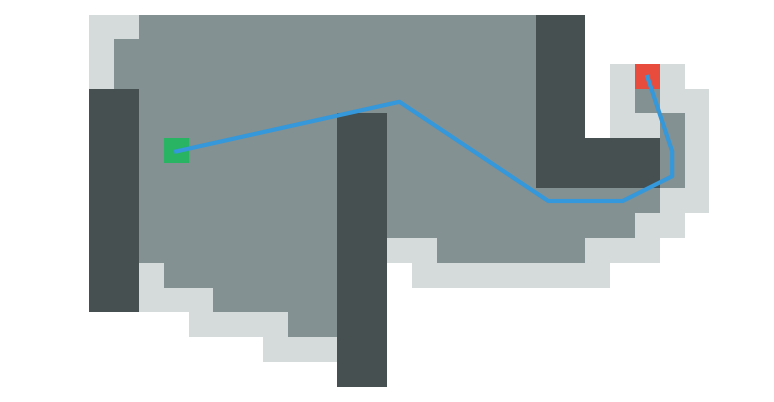

Path found! Length: 25.829. Tree size: 300. Number of steps: 178. Correct: True.
CPU times: user 66.8 ms, sys: 0 ns, total: 66.8 ms
Wall time: 65.3 ms


In [36]:
%time simple_test(thetastar, 6, True, euclidean_distance, SearchTreePQD)

In [37]:
%time massive_test(thetastar, euclidean_distance, SearchTreePQD)

Path found! Length: 28.631. Tree size: 313. Number of steps: 170. Correct: True.
Path found! Length: 23.013. Tree size: 304. Number of steps: 81. Correct: True.
Path found! Length: 24.549. Tree size: 327. Number of steps: 91. Correct: True.
Path found! Length: 14.881. Tree size: 67. Number of steps: 12. Correct: True.
Path found! Length: 22.359. Tree size: 279. Number of steps: 74. Correct: True.
Path found! Length: 20.028. Tree size: 272. Number of steps: 90. Correct: True.
Path found! Length: 25.829. Tree size: 300. Number of steps: 178. Correct: True.
Path found! Length: 20.008. Tree size: 189. Number of steps: 59. Correct: True.
Path found! Length: 31.797. Tree size: 339. Number of steps: 230. Correct: True.
Path found! Length: 18.365. Tree size: 169. Number of steps: 38. Correct: True.
Path found! Length: 27.479. Tree size: 316. Number of steps: 218. Correct: True.
Path found! Length: 30.498. Tree size: 339. Number of steps: 215. Correct: True.
Path found! Length: 20.786. Tree siz